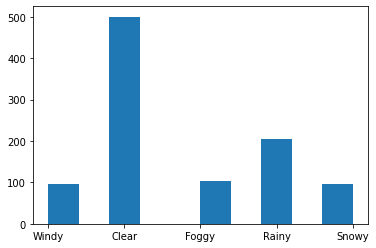

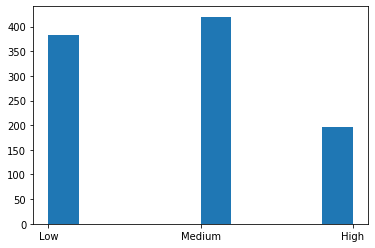

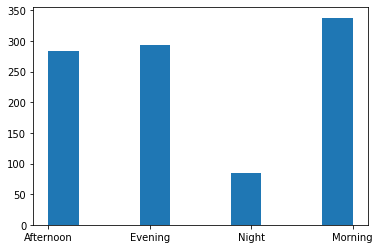

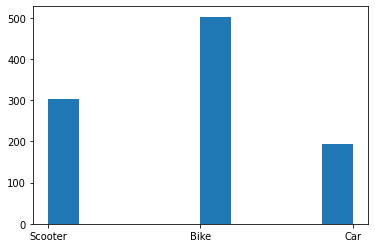

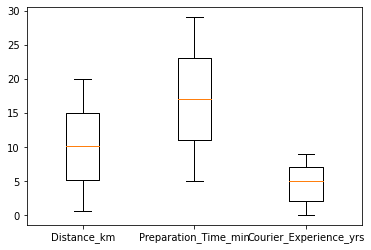

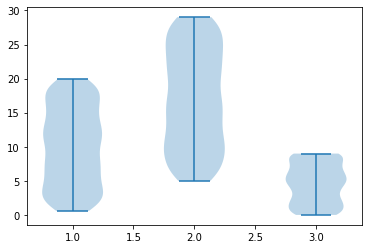

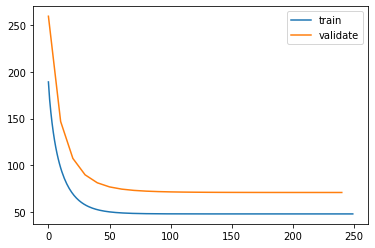

batch mse: 72.06130236186358
batch r2_score: 0.7588779841231409


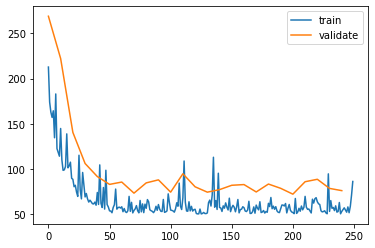

mini_batch mse: 104.84824952882794
mini_batch r2_score: 0.6491706302975406


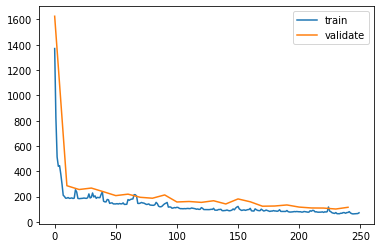

stochastic mse: 114.99150742608795
stochastic r2_score: 0.6152305999125145
ridge mse: 243.00081712787195
lasso mse: 106.48982822242057


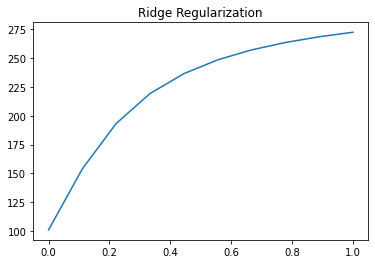

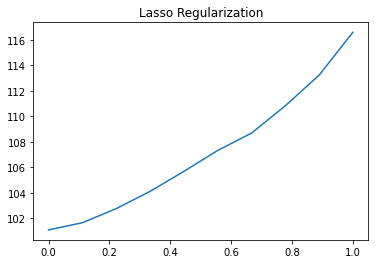

In [ ]:
'''
This code handles missing, categroical values, plots histograms, violin plots etc and also does feature scaling and splitting
and performs linear regression using gradient descent with batch, mini-batch, stochastic and also with regularization
'''

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

df = pd.read_csv('Food_Delivery_Times(in).csv')
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['number']).columns[1:-1]
# print(numerical_cols)

categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='median')

df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

for col in categorical_cols:
    # histogram
    plt.hist(df[col])
    plt.show()

# boxplot
plt.boxplot([df[col] for col in numerical_cols],labels=numerical_cols)
plt.show()
#violin plot
plt.violinplot([df[col] for col in numerical_cols])
plt.show()

#one hot encoding
df = pd.get_dummies(df,columns=categorical_cols)

#split
train,test = train_test_split(df,train_size  = 0.7,test_size=0.3)
test,validate = train_test_split(test,test_size = 0.5)



#feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.fit_transform(test[numerical_cols])
validate[numerical_cols] = scaler.fit_transform(validate[numerical_cols])
#remove the first column
train = train.drop(columns=['Order_ID'])
test = test.drop(columns=['Order_ID'])
validate = validate.drop(columns=['Order_ID'])


'''
linear regression using gradient descent
batch, mini-batch, stochastic
'''




import numpy as np
# np.random.seed(2)


def mse(datapoints, weights,w0):
    '''
    Mean Squared Error
    '''
    # print(weights[0])
    return np.mean((datapoints[:, -1] - np.dot(datapoints[:, :-1], weights) - w0)**2)/2

def r2_score(datapoints, weights,w0):
    '''
    R2 Score
    '''
    y_pred = np.dot(datapoints[:, :-1], weights) + w0
    y_mean = np.mean(datapoints[:, -1])
    ss_total = np.sum((datapoints[:, -1] - y_mean)**2)
    ss_res = np.sum((datapoints[:, -1] - y_pred)**2)
    return 1 - ss_res/ss_total

def gradient_descent(datapoints, validate, learning_rate, iterations,batch_size,regularization=None,lambda_reg=None):
    '''
    Gradient Descent
    '''
    weights = np.zeros(datapoints.shape[1] - 1)
    w0 = 0
    mse_values = []
    mse_values_validate = [] # every ten interations
    for _ in range(iterations):
        #choose random batch_size number of datapoints
        random_indices = np.random.choice(datapoints.shape[0], batch_size, replace=False)
        batch = datapoints[random_indices]
        w0 = w0 + learning_rate * np.mean(batch[:, -1] - np.dot(batch[:, :-1], weights) - w0)
        gradient = np.mean((batch[:, -1] - np.dot(batch[:, :-1], weights) - w0)[:, None] * batch[:, :-1], axis=0)
        # weights = weights + learning_rate * np.mean((batch[:, -1] - np.dot(batch[:, :-1], weights) - w0)[:, None] * batch[:, :-1], axis=0)
        if regularization == 'lasso':
            weights = weights + learning_rate * (gradient - lambda_reg * np.sign(weights))
        elif regularization == 'ridge':
            weights = weights + learning_rate * (gradient - lambda_reg * weights)
        else:
            weights = weights + learning_rate * gradient
        mse_values.append(mse(datapoints, weights,w0))
        mse_values_validate.append(mse(validate, weights,w0))
    
    #keep only every tenth value in mse_values_validate
    mse_values_validate = mse_values_validate[::10]
    #plot both mse_values and mse_values_validate
    if regularization == None:
        plt.plot(range(iterations), mse_values, label='train')
        plt.plot(range(0, iterations, 10), mse_values_validate, label='validate')
        plt.legend()
        plt.show()
    
    return weights, w0

x_train = train.drop(columns=['Delivery_Time_min']).to_numpy()
y_train = train['Delivery_Time_min'].to_numpy()
datapoints = np.column_stack((x_train, y_train))
# print(datapoints)
x_validate = validate.drop(columns=['Delivery_Time_min']).to_numpy()
y_validate = validate['Delivery_Time_min'].to_numpy()
validate_datapoints = np.column_stack((x_validate, y_validate))
learning_rate = 0.5

x_test = test.drop(columns=['Delivery_Time_min']).to_numpy()
y_test = test['Delivery_Time_min'].to_numpy()
test_datapoints = np.column_stack((x_test, y_test))

#batch gradient descent
batch_weights, batch_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=datapoints.shape[0])
# print('batch_weights:', batch_weights)

print('batch mse:', mse(test_datapoints, batch_weights, batch_w0))
print('batch r2_score:', r2_score(test_datapoints, batch_weights, batch_w0))

#mini-batch gradient descent
batch_size = 10
mini_batch_weights, mini_batch_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size)
print('mini_batch mse:', mse(test_datapoints, mini_batch_weights, mini_batch_w0))
print('mini_batch r2_score:', r2_score(test_datapoints, mini_batch_weights, mini_batch_w0))

learning_rate = 0.05
#stochastic gradient descent
stochastic_weights, stochastic_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=1)
print('stochastic mse:', mse(test_datapoints, stochastic_weights, stochastic_w0))
print('stochastic r2_score:', r2_score(test_datapoints, stochastic_weights, stochastic_w0))


lamda = 0.5
ridge_weights, ridge_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=datapoints.shape[0], regularization='ridge', lambda_reg=lamda)
print('ridge mse:', mse(test_datapoints, ridge_weights, ridge_w0))

lasso_weights, lasso_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=datapoints.shape[0], regularization='lasso', lambda_reg=lamda)
print('lasso mse:', mse(test_datapoints, lasso_weights, lasso_w0))

lamda_values = np.linspace(0, 1, 10)
mses = []
for lamda in lamda_values:
    ridge_weights, ridge_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=datapoints.shape[0], regularization='ridge', lambda_reg=lamda)
    mses.append(mse(test_datapoints, ridge_weights, ridge_w0))
plt.plot(lamda_values, mses)
plt.title('Ridge Regularization')
plt.show()

mses = []
for lamda in lamda_values:
    lasso_weights, lasso_w0 = gradient_descent(datapoints, validate_datapoints, learning_rate, 250, batch_size=datapoints.shape[0], regularization='lasso', lambda_reg=lamda)
    mses.append(mse(test_datapoints, lasso_weights, lasso_w0))
plt.plot(lamda_values, mses)
plt.title('Lasso Regularization')
plt.show()



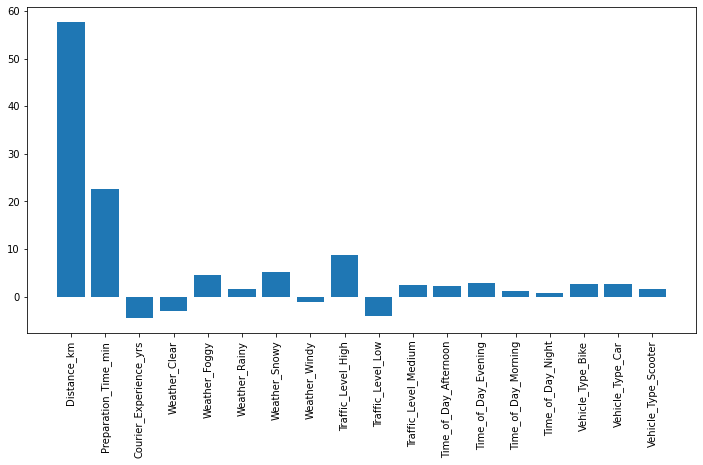

In [7]:
# bar plot of weights
import matplotlib.pyplot as plt

# I want the labels in x axis to be the column names, except Delivery_Time_min

plt.figure(figsize=(12, 6))
plt.bar(train.drop(columns=['Delivery_Time_min']).columns, batch_weights)
plt.xticks(rotation=90)
plt.show()

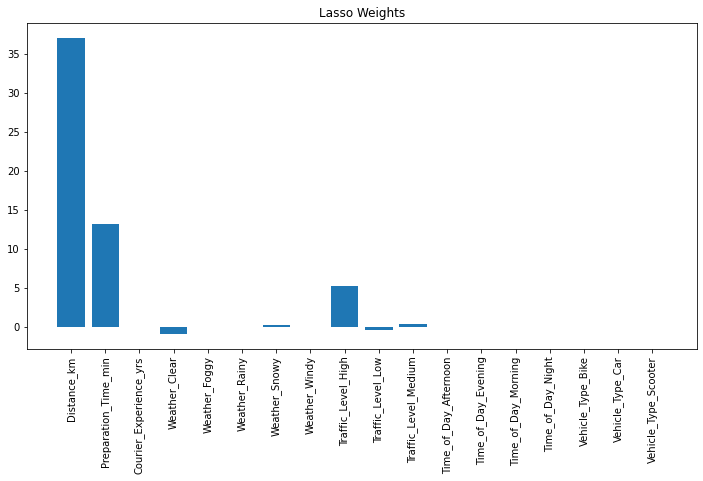

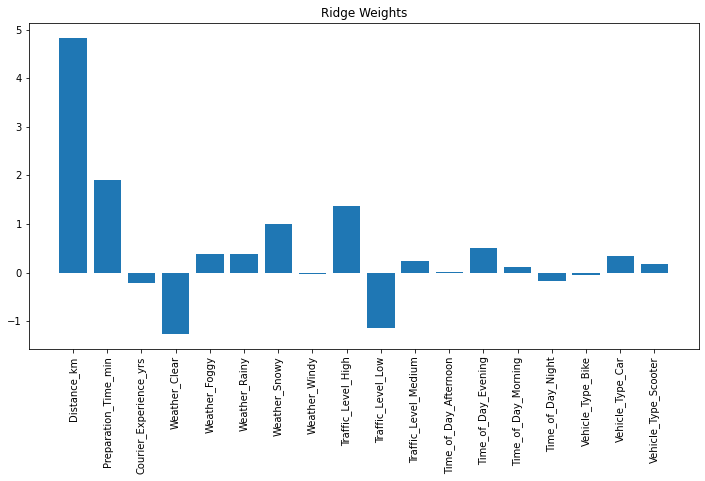

In [8]:
# batch weights for lasso and ridge and plot them
plt.figure(figsize=(12, 6))
plt.bar(train.drop(columns=['Delivery_Time_min']).columns, lasso_weights)
plt.xticks(rotation=90)
plt.title('Lasso Weights')
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(train.drop(columns=['Delivery_Time_min']).columns, ridge_weights)
plt.xticks(rotation=90)
plt.title('Ridge Weights')
plt.show()